<a href="https://colab.research.google.com/github/ambika1us/Hate-Speech-Detection-using-LSTM/blob/main/Hate_Speech_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Importent Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import spacy
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Hate Speech Detection using LSTM/labeled_data.csv')

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


In [ ]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [ ]:
df.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)

In [ ]:
df

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [ ]:
#Deleting unwanted symbols & Numeric data
df['Processed_tweet'] = df['tweet'].str.replace("[^a-zA-Z#]", " ",regex=True)

In [ ]:
#Handling unwanted space
df['Processed_tweet_2']=df['Processed_tweet'].str.replace('\s+', ' ',regex=True)

In [ ]:
df['Processed_tweet'].iloc[0]

'    RT  mayasolovely  As a woman you shouldn t complain about cleaning up your house   amp  as a man you should always take the trash out   '

In [ ]:
df['Processed_tweet_2'].iloc[0]

' RT mayasolovely As a woman you shouldn t complain about cleaning up your house amp as a man you should always take the trash out '

In [ ]:
#Deleting unwanted columns
df.drop(columns=['tweet','Processed_tweet'], inplace=True)

In [ ]:
#NLP
nlp=spacy.load('en_core_web_sm')

In [ ]:
#Lemmatization
def lemmatization(text):
  doc=nlp(text)
  lemmalist=(word.lemma_ for word in doc)
  return " ".join(lemmalist)

In [ ]:
df['lemma_tweet']=df['Processed_tweet_2'].apply(lemmatization)

In [ ]:
#Remove the stopwords
def remove_stopwords(text):
  doc=nlp(text)
  no_stopword_list=(word.text for word in doc if not word.is_stop)
  return " ".join(no_stopword_list)

In [ ]:
df['Final_tweet']=df['lemma_tweet'].apply(remove_stopwords)

In [ ]:
#One Hot represention
vocab_size=10000
onehot_repr=[one_hot(words,vocab_size) for words in df['Final_tweet']]

In [ ]:
sentence_length=20
embedded_tweet=pad_sequences(onehot_repr,padding='pre',maxlen=sentence_length)

In [ ]:
for i in range(0,4):
  print(embedded_tweet[i])

[   0    0    0    0    0    0    0    0    0 4450 6897 2094 7715 4924
 5986 6218 9246 2991 4323 2321]
[   0    0    0    0    0    0    0 4450 8131 7556  959 8792 7394 3422
 1751 6152  959 8518 2568 3922]
[   0    0    0    0    0    0    0    0 4450 8894 1433 4450  574 7626
 8059  310 2238 9473 9412 2467]
[   0    0    0    0    0    0    0    0    0    0    0 4450 5342 1847
 3935 5939 3803 5196 6021 6544]


In [ ]:
X=np.array(embedded_tweet)
y=np.array(df['class'])

In [ ]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [ ]:
smote=SMOTE(sampling_strategy='minority')
X,y=smote.fit_resample(X,y)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
#Creating Models
dimension=50
model=keras.Sequential([
    keras.layers.Embedding(vocab_size,dimension,input_length=sentence_length),
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(3,activation='softmax')
    ])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',

    metrics=['accuracy'])

In [ ]:
print(model.summary())

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(
        input_dim=500, output_dim=128, input_shape=(100,)
    ),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax')
])
model.summary() # OK

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 128)            │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100, 64)             │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100, 32)             │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100, 10)             │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,666 (291.66 KB)

 Trainable params: 74,666 (291.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 60s 51ms/step - accuracy: 0.7723 - loss: 0.5123
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.9442 - loss: 0.1696
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 50s 47ms/step - accuracy: 0.9638 - loss: 0.1161
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - accuracy: 0.9721 - loss: 0.0929
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 52s 49ms/step - accuracy: 0.9768 - loss: 0.0758
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.9817 - loss: 0.0558
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 79s 47ms/step - accuracy: 0.9858 - loss: 0.0435
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.9912 - loss: 0.0279
Epoch 9/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 86s 50ms/step - accuracy: 0.9933 - loss: 0.0211
Epoch 10/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.9953 - loss: 0.0146


In [ ]:
loss,accuracy=model.evaluate(X_test,y_test)
print(f"Loss: {loss*100}")
print(f"Accuracy: {accuracy*100}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8929 - loss: 0.6825
Loss: 69.52347755432129
Accuracy: 89.05864357948303


In [ ]:
pred=np.argmax(model.predict(X_test),axis=-1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [ ]:
y_test[:5]

array([1, 1, 0, 1, 2])

In [ ]:
pred[:5]

array([1, 1, 0, 1, 2])

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3812
           1       0.92      0.89      0.91      3807
           2       0.68      0.76      0.72       890

    accuracy                           0.89      8509
   macro avg       0.84      0.86      0.85      8509
weighted avg       0.89      0.89      0.89      8509



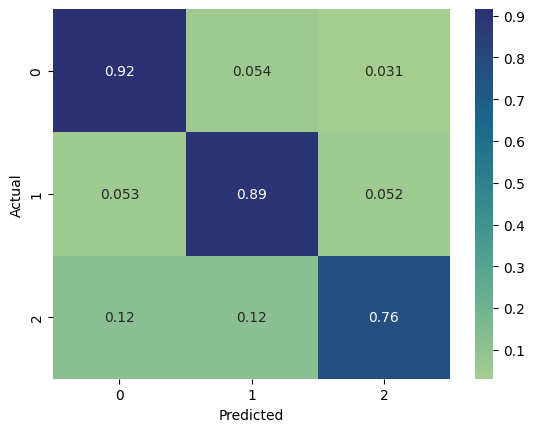

In [ ]:
cf=confusion_matrix(y_test,pred,normalize='true')
sns.heatmap(cf,annot=True, cmap='crest');
plt.xlabel('Predicted');
plt.ylabel('Actual');